<a href="https://colab.research.google.com/github/foxiegh/IS3107-Project/blob/main/IS3107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Common Libraries needed
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time
import random
import urllib
import json
import geopy.distance
from sklearn.preprocessing import StandardScaler
from math import dist
from geopy.distance import geodesic as GD
import torch.nn as nn

from io import StringIO
from pandas import json_normalize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# url = 'https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3'
# fileobj = urllib.urlopen(url)
# print(fileobj.read())

In [ ]:
#To insert data from an Airflow DAG into a MySQL database, you can use the MySqlHook provided by Airflow. Here are the steps you can follow:

#from airflow.hooks.mysql_hook import MySqlHook
#from datetime import datetime
#mysql_hook = MySqlHook(mysql_conn_id='your_mysql_connection_id')
#conn = mysql_hook.get_conn()
#data = {'column1': value1, 'column2': value2, 'column3': value3}
#table_name = 'your_table_name'
#insert_stmt = f"INSERT INTO {table_name} (column1, column2, column3) VALUES (%s, %s, %s)"
#cursor = conn.cursor()
#cursor.execute(insert_stmt, (data['column1'], data['column2'], data['column3']))
#conn.commit()
#conn.close()


#Max is 129187, I limit to 5 for testing first

In [ ]:
# Use this for files on google drive
# drive.mount("/content/drive")

In [ ]:
retry_collect_data = False
if retry_collect_data:
  base_url = "https://data.gov.sg"
  url = base_url + '/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3'
  data = requests.get(url).json()
  # print(json.dumps(data, indent= 2))


  df = pd.DataFrame(data['result']['records'])
  df.to_csv("/content/drive/My Drive/IS3107/housing_main_df.csv", index=False)
  print("collected data for {}".format(url))
  import traceback
  while True:
    try:
        
      f = open("demofile3.txt", "r")
      url_for_today = f.read()
      f.close()  

      next = data["result"]["_links"]["next"]
      #url is the next page
      url_for_tmr = base_url + next
      # Save into the file
      
      f = open("demofile3.txt", "w")
      f.write(url_for_tmr)
      f.close()  
      

      while True:
        time.sleep(0.35)
        try:
          data = requests.get(url).json()
          df = pd.DataFrame(data['result']['records'])
          break
        except:
          print(json.dumps(data, indent = 2))
          traceback.print_exc()
      if len(df) == 0:
        break
      df.to_csv("/content/drive/My Drive/IS3107/housing_main_df.csv", index=False, header=False, mode="a")
      print("collected data for {}".format(url))
    except:
      print(json.dumps(data, indent = 2))
      traceback.print_exc()
  df = pd.read_csv("/content/drive/My Drive/IS3107/housing_main_df.csv")
  print(df.shape)
  df.head()

# Transforming the dataset (Adding 'Address', 'latitude', 'longitude' and 'nearest mrt' columns')

In [ ]:
if retry_collect_data:
  df = pd.read_csv("/content/drive/My Drive/IS3107/housing_main_df.csv")
  df['address'] = df['block'] + " " + df['street_name']
  try:
    add_found = pd.read_csv("/content/drive/My Drive/IS3107/address_lat_long_df.csv")
    first_time = False
  except:
    first_time = True
  for index, row in df.iterrows():
    if len(add_found[add_found["_id"] == row["_id"]]):
      continue
    dat = dict()
    for k in row.index:
      if k == "address":
        response_data = requests.get("https://developers.onemap.sg/commonapi/search?searchVal=" + row[k] + "&returnGeom=Y&getAddrDetails=N&pageNum=1")
        try:
          data2 = json.loads(response_data.text)
        except:
          print(response_data.text)
          break
        # Retrieve the latitude value
        latitude = data2['results'][0]['LATITUDE']
        # Retrieve the longitude value
        longitude = data2['results'][0]['LONGITUDE']
        dat["latitude"] = latitude
        dat["longitude"] = longitude
      dat[k] = [row[k]]
    if first_time:
      pd.DataFrame(dat).to_csv("/content/drive/My Drive/IS3107/address_lat_long_df.csv", index=False)
      first_time = False
    else:
      pd.DataFrame(dat).to_csv("/content/drive/My Drive/IS3107/address_lat_long_df.csv", index=False, header=False, mode="a")

## Adding 'Address, 'Latitude' and 'Longitude'

In [ ]:
retry_collect_data_all = False
if retry_collect_data_all:

  df['address'] = df['block'] + " " + df['street_name']

  #df.drop(['month', 'remaining_lease', 'lease_commence_date'], axis=1)

  lat_list = []
  long_list = []

  #Adding latitude and longitude
  for add in df['address']:
    response_data = requests.get("https://developers.onemap.sg/commonapi/search?searchVal=" + add + "&returnGeom=Y&getAddrDetails=N&pageNum=1")

    # Parse response data into a dictionary
    data2 = json.loads(response_data.text)

    # Retrieve the latitude value
    latitude = data2['results'][0]['LATITUDE']
    # Retrieve the longitude value
    longitude = data2['results'][0]['LONGITUDE']

    lat_list.append(latitude)
    long_list.append(longitude)

  df['latitude'] = lat_list
  df['longitude'] = long_list
  df

## Adding Nearest MRT

In [ ]:
retry_collect_mrtdf = False
if retry_collect_mrtdf:
  stationCodes = "https://docs.google.com/spreadsheets/d/1z1ImXo02Rvf-PTpvuw1ad9ETy-7GaFY6/export"
  mrtdf = pd.read_excel(stationCodes, engine='xlrd')

In [ ]:
#Find list of mrts and their names from https://datamall.lta.gov.sg/content/datamall/en/search_datasets.html?searchText=mrt
#Deleted BP14 due to removal from OneMap API
if False:
  mrtdf = pd.read_excel('/content/drive/My Drive/IS3107/Station_Codes.xls')
  mrtdf = mrtdf.drop(columns = ['mrt_station_english', 'mrt_station_chinese', 'mrt_line_english', 'mrt_line_chinese'])

  mrtList = []
  for code in mrtdf['stn_code']:
    mrtList.append(code)

  print(mrtList)

  #Create Latitude and longitude columns for the mrt using OneMap API

  mrtURL = "https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=N&searchVal="

  mrtLat = []
  mrtLong = []
  for code in mrtList:
    #API Call
    response_data = requests.get(mrtURL + code)
    data3 = json.loads(response_data.text)

    print("code: {}, data3: {}".format(code, data3))
    # Retrieve the latitude value
    if data3["found"] > 0:
      
      latitude = data3['results'][0]['LATITUDE']
      # Retrieve the longitude value
      longitude = data3['results'][0]['LONGITUDE']
    else:
      latitude = np.nan
      longitude = np.nan
    mrtLat.append(latitude)
    mrtLong.append(longitude)

  print(len(mrtLat))

  mrtdf['latitude'] = mrtLat
  mrtdf['longitude'] = mrtLong
  mrtdf.to_csv('/content/drive/My Drive/IS3107/mrtdf.csv')
else:
  mrtdf = pd.read_csv('/content/drive/My Drive/IS3107/mrtdf.csv')
mrtdf.iloc[155]

Unnamed: 0           156
stn_code             STC
latitude        1.391609
longitude     103.895443
Name: 155, dtype: object

In [ ]:
if retry_collect_data:
  add_found = pd.read_csv("/content/drive/My Drive/IS3107/address_lat_long_df.csv")
  closest_mrt_df = None
  try:
    closest_mrt_df = pd.read_csv("/content/drive/My Drive/IS3107/closest_mrt_df.csv")
    first_time = False
  except:
    first_time = True

  for index, row in add_found.iterrows():
    if closest_mrt_df is not None and len(closest_mrt_df[closest_mrt_df["_id"] == row["_id"]]):
      continue
    dat = dict()
    selectedHDB =(row['latitude'], row['longitude'])
    nearestMrt = mrtdf['stn_code'][0]
    shortestDist = GD(selectedHDB, (mrtdf['latitude'][0],mrtdf['longitude'][0]) )
    for k in row.index:
      dat[k] = [row[k]]
    for index2, row2 in mrtdf.iterrows():
      selectedMrt = (row2['latitude'],row2['longitude'])
      if not np.isnan(selectedMrt[0]): 
        distToSelectedMrt = GD(selectedHDB, selectedMrt)
        if shortestDist > distToSelectedMrt:
          nearestMrt = row2['stn_code']
          shortestDist = distToSelectedMrt
    dat["nearest_mrt"] = [nearestMrt]
    dat["distance_to_nearest_mrt"] = [shortestDist]
    if first_time:
      pd.DataFrame(dat).to_csv("/content/drive/My Drive/IS3107/closest_mrt_df.csv", index=False)
      first_time = False
    else:
      pd.DataFrame(dat).to_csv("/content/drive/My Drive/IS3107/closest_mrt_df.csv", index=False, header=False, mode="a")
  closest_mrt_df = pd.read_csv("/content/drive/My Drive/IS3107/closest_mrt_df.csv")
else:
  closest_mrt_df = pd.read_csv("/content/drive/My Drive/IS3107/closest_mrt_df.csv")
closest_mrt_df

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block,latitude,longitude,address,nearest_mrt,distance_to_nearest_mrt
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,2017-01,61 years 04 months,1979,10 TO 12,1,406,1.362005,103.853880,406 ANG MO KIO AVE 10,NS16,0.9999410460932074 km
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,2017-01,60 years 07 months,1978,01 TO 03,2,108,1.370943,103.837975,108 ANG MO KIO AVE 4,TE6,0.16682595421967258 km
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,2017-01,62 years 05 months,1980,01 TO 03,3,602,1.380709,103.835368,602 ANG MO KIO AVE 5,TE5,0.5321550545996467 km
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,2017-01,62 years 01 month,1980,04 TO 06,4,465,1.366201,103.857201,465 ANG MO KIO AVE 10,NS16,0.9453750553578684 km
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,2017-01,62 years 05 months,1980,01 TO 03,5,601,1.381041,103.835132,601 ANG MO KIO AVE 5,TE5,0.4984196462099258 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,YISHUN,EXECUTIVE,Maisonette,146.0,YISHUN CTRL,800000.0,2023-03,64 years 08 months,1988,10 TO 12,149996,325,1.429239,103.842146,325 YISHUN CTRL,NS13,0.7949688525478285 km
149996,YISHUN,EXECUTIVE,Maisonette,146.0,YISHUN RING RD,800000.0,2023-03,64 years 06 months,1988,01 TO 03,149997,356,1.425311,103.845456,356 YISHUN RING RD,NS13,1.2495539600749204 km
149997,YISHUN,EXECUTIVE,Apartment,142.0,YISHUN RING RD,770000.0,2023-03,64 years 03 months,1988,04 TO 06,149998,387,1.429547,103.847279,387 YISHUN RING RD,NS13,1.3659493996453895 km
149998,YISHUN,EXECUTIVE,Maisonette,146.0,YISHUN RING RD,818000.0,2023-03,63 years 05 months,1987,10 TO 12,149999,792,1.420500,103.832376,792 YISHUN RING RD,NS14,0.3511514608940772 km


In [ ]:
df = pd.read_csv("/content/drive/My Drive/IS3107/closest_mrt_df.csv")
print(df.dtypes)
df

town                        object
flat_type                   object
flat_model                  object
floor_area_sqm             float64
street_name                 object
resale_price               float64
month                       object
remaining_lease             object
lease_commence_date          int64
storey_range                object
_id                          int64
block                       object
latitude                   float64
longitude                  float64
address                     object
nearest_mrt                 object
distance_to_nearest_mrt     object
dtype: object


,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block,latitude,longitude,address,nearest_mrt,distance_to_nearest_mrt
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,2017-01,61 years 04 months,1979,10 TO 12,1,406,1.362005,103.853880,406 ANG MO KIO AVE 10,NS16,0.9999410460932074 km
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,2017-01,60 years 07 months,1978,01 TO 03,2,108,1.370943,103.837975,108 ANG MO KIO AVE 4,TE6,0.16682595421967258 km
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,2017-01,62 years 05 months,1980,01 TO 03,3,602,1.380709,103.835368,602 ANG MO KIO AVE 5,TE5,0.5321550545996467 km
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,2017-01,62 years 01 month,1980,04 TO 06,4,465,1.366201,103.857201,465 ANG MO KIO AVE 10,NS16,0.9453750553578684 km
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,2017-01,62 years 05 months,1980,01 TO 03,5,601,1.381041,103.835132,601 ANG MO KIO AVE 5,TE5,0.4984196462099258 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80267,YISHUN,4 ROOM,Simplified,88.0,YISHUN RING RD,315000.0,2020-09,63 years 05 months,1985,01 TO 03,80268,252,1.434687,103.841154,252 YISHUN RING RD,NS13,0.896888578989315 km
80268,YISHUN,4 ROOM,Simplified,84.0,YISHUN RING RD,323000.0,2020-09,65 years 08 months,1987,07 TO 09,80269,312,1.431417,103.841457,312 YISHUN RING RD,NS13,0.7504759108031983 km
80269,YISHUN,4 ROOM,Simplified,83.0,YISHUN RING RD,330000.0,2020-09,65 years 07 months,1987,04 TO 06,80270,619,1.419115,103.834935,619 YISHUN RING RD,NS14,0.2898303467975187 km
80270,YISHUN,4 ROOM,Model A,104.0,YISHUN RING RD,400000.0,2020-09,67 years,1988,10 TO 12,80271,854,1.416597,103.837403,854 YISHUN RING RD,NS14,0.49983705037849513 km


# Data convertion from objects into numeric

In [ ]:
df["remaining_lease"] = df["remaining_lease"].str.findall(r'\d+ years').str[0].str.findall(r'\d+').str[0].fillna(0).astype(int) * 12 \
          + df["remaining_lease"].str.findall(r'\d+ months').str[0].str.findall(r'\d+').str[0].fillna(0).astype(int)
df["distance_to_nearest_mrt"] = df["distance_to_nearest_mrt"].str.findall(r'\d+.\d+').str[0].fillna(0).astype(np.float32)
df["latitude"] = df["latitude"].astype(np.float32)
df["longitude"] = df["longitude"].astype(np.float32)
df["resale_days_since_2017"] = (pd.to_datetime(df["month"], format="%Y-%m") - pd.to_datetime("2017-01-01")).dt.days
df = df.drop(["month"], axis=1)
df.dtypes

town                        object
flat_type                   object
flat_model                  object
floor_area_sqm             float64
street_name                 object
resale_price               float64
remaining_lease              int64
lease_commence_date          int64
storey_range                object
_id                          int64
block                       object
latitude                   float32
longitude                  float32
address                     object
nearest_mrt                 object
distance_to_nearest_mrt    float32
resale_days_since_2017       int64
dtype: object

# Add total number of sales per town

In [ ]:
aggregate_result=pd.DataFrame({'number_sold_in_same_town_month':df.groupby(["town","resale_days_since_2017"])[['town','resale_days_since_2017']].size()}).reset_index()
df = df.merge(aggregate_result, on=["town","resale_days_since_2017"])
df

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,remaining_lease,lease_commence_date,storey_range,_id,block,latitude,longitude,address,nearest_mrt,distance_to_nearest_mrt,resale_days_since_2017,number_sold_in_same_town_month
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,736,1979,10 TO 12,1,406,1.362005,103.853882,406 ANG MO KIO AVE 10,NS16,0.999941,0,56
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,727,1978,01 TO 03,2,108,1.370943,103.837975,108 ANG MO KIO AVE 4,TE6,0.166826,0,56
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,749,1980,01 TO 03,3,602,1.380709,103.835365,602 ANG MO KIO AVE 5,TE5,0.532155,0,56
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,744,1980,04 TO 06,4,465,1.366201,103.857201,465 ANG MO KIO AVE 10,NS16,0.945375,0,56
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,749,1980,01 TO 03,5,601,1.381041,103.835129,601 ANG MO KIO AVE 5,TE5,0.498420,0,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80267,YISHUN,4 ROOM,Simplified,88.0,YISHUN RING RD,315000.0,761,1985,01 TO 03,80268,252,1.434687,103.841156,252 YISHUN RING RD,NS13,0.896889,1339,91
80268,YISHUN,4 ROOM,Simplified,84.0,YISHUN RING RD,323000.0,788,1987,07 TO 09,80269,312,1.431417,103.841461,312 YISHUN RING RD,NS13,0.750476,1339,91
80269,YISHUN,4 ROOM,Simplified,83.0,YISHUN RING RD,330000.0,787,1987,04 TO 06,80270,619,1.419115,103.834938,619 YISHUN RING RD,NS14,0.289830,1339,91
80270,YISHUN,4 ROOM,Model A,104.0,YISHUN RING RD,400000.0,804,1988,10 TO 12,80271,854,1.416597,103.837402,854 YISHUN RING RD,NS14,0.499837,1339,91


# Remove unused columns

In [ ]:
df = df.drop(["_id", "latitude", "longitude", "block", "address", "street_name"], axis=1)
df

,town,flat_type,flat_model,floor_area_sqm,resale_price,remaining_lease,lease_commence_date,storey_range,nearest_mrt,distance_to_nearest_mrt,resale_days_since_2017,number_sold_in_same_town_month
0,ANG MO KIO,2 ROOM,Improved,44.0,232000.0,736,1979,10 TO 12,NS16,0.999941,0,56
1,ANG MO KIO,3 ROOM,New Generation,67.0,250000.0,727,1978,01 TO 03,TE6,0.166826,0,56
2,ANG MO KIO,3 ROOM,New Generation,67.0,262000.0,749,1980,01 TO 03,TE5,0.532155,0,56
3,ANG MO KIO,3 ROOM,New Generation,68.0,265000.0,744,1980,04 TO 06,NS16,0.945375,0,56
4,ANG MO KIO,3 ROOM,New Generation,67.0,265000.0,749,1980,01 TO 03,TE5,0.498420,0,56
...,...,...,...,...,...,...,...,...,...,...,...,...
80267,YISHUN,4 ROOM,Simplified,88.0,315000.0,761,1985,01 TO 03,NS13,0.896889,1339,91
80268,YISHUN,4 ROOM,Simplified,84.0,323000.0,788,1987,07 TO 09,NS13,0.750476,1339,91
80269,YISHUN,4 ROOM,Simplified,83.0,330000.0,787,1987,04 TO 06,NS14,0.289830,1339,91
80270,YISHUN,4 ROOM,Model A,104.0,400000.0,804,1988,10 TO 12,NS14,0.499837,1339,91


# Data Exploration

town                               object
flat_type                          object
flat_model                         object
floor_area_sqm                    float64
resale_price                      float64
remaining_lease                     int64
lease_commence_date                 int64
storey_range                       object
nearest_mrt                        object
distance_to_nearest_mrt           float32
resale_days_since_2017              int64
number_sold_in_same_town_month      int64
dtype: object


<Axes: >

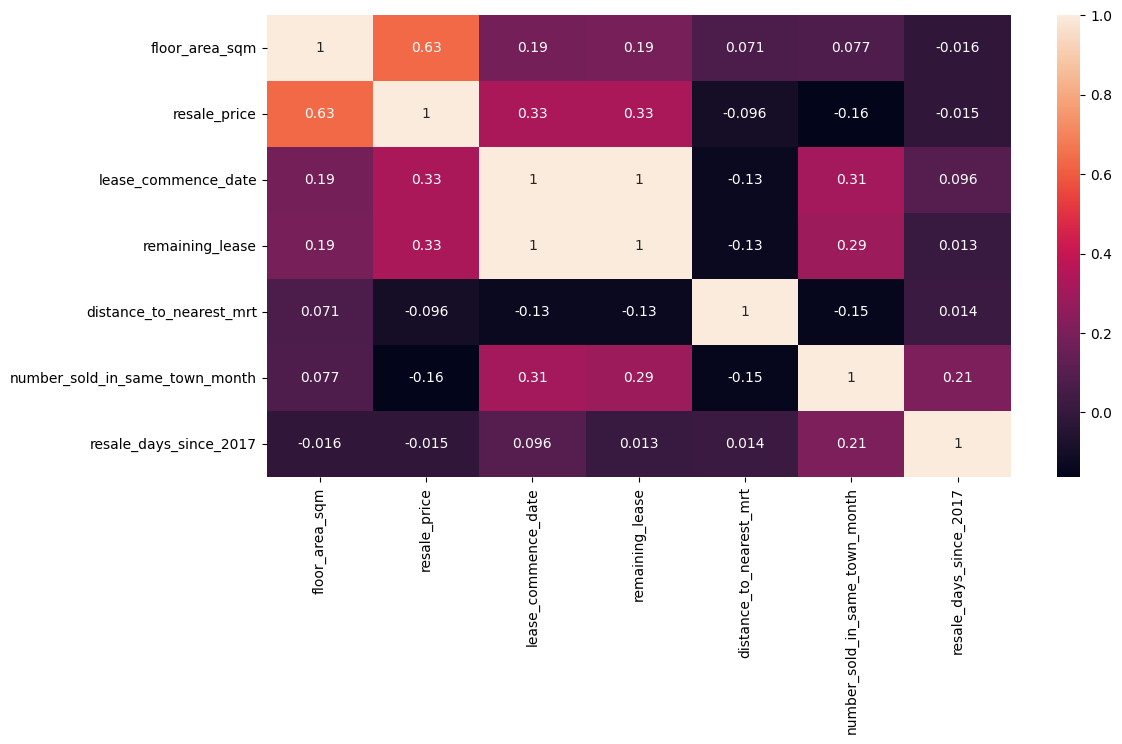

In [ ]:
numeric_col = ["floor_area_sqm", "resale_price", "lease_commence_date", "remaining_lease", "distance_to_nearest_mrt", "number_sold_in_same_town_month", "resale_days_since_2017"]
print(df.dtypes)

# scaling the resale price
# df['resale_price'] /= 1000

# correlation matrix
correlation = df[numeric_col].corr()
# heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

In [ ]:
# pair plot
sns.pairplot(df[numeric_col])

Error in callback <function flush_figures at 0x7f69fc889940> (for post_execute):


KeyboardInterrupt: ignored

# Remove closely correlated columns

In [ ]:
# To be done
df = df.drop(["lease_commence_date"], axis=1)

#  Scaling, Normalization, and Standardization data

In [ ]:
# scaling the resale price
df['resale_price'] /= 1000

# Checking for Outlier 

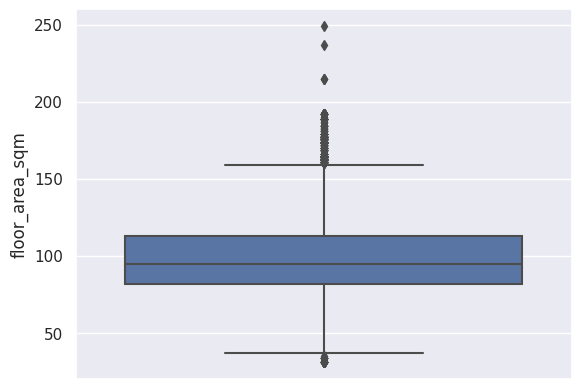

In [ ]:
sns.set()
ax = sns.boxplot(y=df['floor_area_sqm'])

In [ ]:
ax = sns.boxplot(y=df['lease_commence_date'])

KeyError: ignored

In [ ]:
ax = sns.boxplot(y=df['resale_price']).set(ylabel ="Resale Price (in 100,000)")

# Binary Encode categorical

In [ ]:
for category in ["town", "flat_type", "flat_model", "storey_range", "nearest_mrt"]:
  encoded = pd.get_dummies(df[[category]], drop_first=True)
  df = pd.concat([df.drop([category], axis=1),encoded], axis=1)
df

## Examine the dataset

In [ ]:
with pd.option_context('display.max_rows', None):
  print(df.dtypes)
df.describe()

# Encoding

We would be adding a feature called `Region`. There are 27 towns grouped into 5 regions. The town to region mapping is based on the following url: https://www.hdb.gov.sg/about-us/history/hdb-towns-your-home

In [ ]:
df1['town'].unique()

In [ ]:
regions = {'NORTH': ['SEMBAWANG', 'WOODLANDS', 'YISHUN'],
 'NORTH-EAST': ['ANG MO KIO', 'HOUGANG', 'PUNGGOL', 'SENGKANG', 'SERANGOON'],
 'EAST': ['BEDOK', 'PASIR RIS', 'TAMPINES'],
 'WEST': ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST', 'TENGAH'],
 'CENTRAL': ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH']}
regions = {k.upper(): [town.upper() for town in towns] for k, towns in regions.items()}
regions = {v: k for k, values in regions.items() for v in values}
df1['region'] = df1['town'].map(regions)

In [ ]:
df1.head()

In [ ]:
sorted(df1['storey_range'].unique())

# Prepare data for prediction

In [ ]:
X = df[["resale_price"]]
y = df.drop(["resale_price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.describe()

# Scale Data for prediction

In [ ]:
normalization_or_standardize = "normalizer"
num_cols = ['floor_area_sqm','remaining_lease','distance_to_nearest_mrt', 'number_sold_in_same_town_month', 'resale_days_since_2017']
if normalization_or_standardize == "standardize":
  # numerical features
  # apply standardization on numerical features
  for i in num_cols:
      # fit on training data column
      scale = StandardScaler().fit(X_train[[i]])
      # transform the training data column
      X_train[i] = scale.transform(X_train[[i]])
      # transform the testing data column
      X_test[i] = scale.transform(X_test[[i]])

elif normalization_or_standardize == "normalizer":
  for i in num_cols:
      # fit on training data column
      norm = MinMaxScaler().fit(X_train[[i]])
      # transform the training data column
      X_train[i] = norm.transform(X_train[[i]])
      # transform the testing data column
      X_test[i] = norm.transform(X_test[[i]])


<Axes: xlabel='a', ylabel='b'>

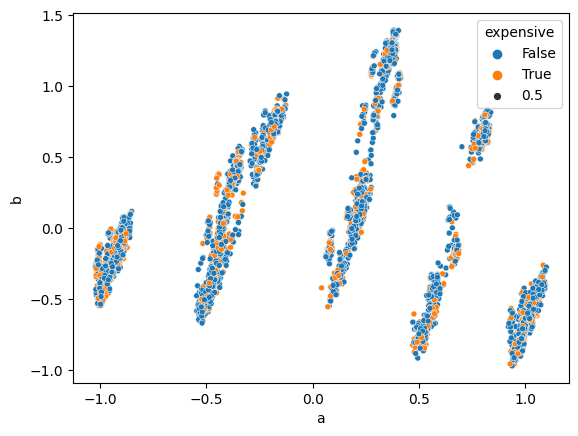

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_p = pd.DataFrame(X_train_pca, columns=["a","b"])
X_p["expensive"] = y["resale_price"] > 480087
sns.scatterplot(data=X_p[:5000], x="a", y="b", hue="expensive",size=0.5)

# Preparation for neural network

In [ ]:
class NumericalPrediction(nn.Module):
    def __init__(self):
        super(NumericalPrediction, self).__init__()
        self.num_layers = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU())
        self.binary_layers = nn.Sequential(
            nn.Linear(211, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU())
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, numerical_inputs, binary_inputs):
        numerical_outputs = self.num_layers(numerical_inputs)
        binary_outputs = self.binary_layers(binary_inputs)
        concatenated_outputs = torch.cat((numerical_outputs, binary_outputs), dim=1)
        final_outputs = self.output_layer(concatenated_outputs)
        return final_outputs

In [ ]:
norm = joblib.load('/content/drive/My Drive/IS3107/advanced_multipart_model_processor.pt')
train_X_numeric = torch.tensor(X_train[num_cols].values, dtype=torch.float32)
train_X_binary = torch.tensor(X_train.drop(num_cols, axis=1).values, dtype=torch.float32)
test_X_numeric = torch.tensor(X_test[num_cols].values, dtype=torch.float32)
test_X_binary = torch.tensor(X_test.drop(num_cols, axis=1).values, dtype=torch.float32)
train_y_ = torch.tensor(y_train.values, dtype=torch.float32)
test_y_ = torch.tensor(y_test.values, dtype=torch.float32)

model = NumericalPrediction()
model.load_state_dict(torch.load('/content/drive/My Drive/IS3107/advanced_multipart_model.pt'))

In [ ]:
pred = model(test_X_numeric, test_X_binary).detach()
print("pred", pred)
print("actual",test_y_)
loss = mean_squared_error(test_y_, pred)
print("squared loss {}".format(loss))
print("loss {}".format(loss**(1/2)))

#  Model training and testing below

# GradientBoostingRegressor

In [ ]:
gbm = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [100,150,200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 15],
    'subsample': [0.8, 0.6],
    'max_features': ['log2']
}

In [ ]:
#grid search with cross-validation to find the best hyperparams

grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [3],
                         'max_features': ['log2'], 'n_estimators': [150],
                         'subsample': [0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
#get the best hyperparams

best_params = grid_search.best_params_
print("Best hyperparameters found: ", best_params)

Best hyperparameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 150, 'subsample': 0.8}


In [ ]:
#train gbm model

best_gbm = GradientBoostingRegressor(**{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 150, 'subsample': 0.8})
best_gbm.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor(learning_rate=0.01, max_features='log2',
                          n_estimators=150, subsample=0.8)

In [ ]:
#predict for test set

y_pred = best_gbm.predict(X_test)

In [ ]:
#some possible evaluations of model performance

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("R-squared: ", r2)

Mean Squared Error:  18952615025.00453
R-squared:  0.31780608400962673


# KNeighborsRegressor

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# Task 4, Q5
knn_model = KNeighborsRegressor()
# Tested n_neighbours = 2/3/4 is best, weights = distance > uniform, p = 1 > 2
param_grid = [{'n_neighbors': [3,4,5,6,7,8,9], 'weights': ['distance', "uniform"],'p':[1,2]}]
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=7, n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)
pd.DataFrame(grid_search.cv_results_)


n= 1
completed fitting
completed predicting
completed test prediction
n= 2
completed fitting
completed predicting
completed test prediction
n= 3
completed fitting
completed predicting
completed test prediction
n= 4
completed fitting
completed predicting
completed test prediction
n= 5
completed fitting
completed predicting
completed test prediction
n= 6
completed fitting
completed predicting
completed test prediction


<Axes: xlabel='n_neighbours', ylabel='value'>

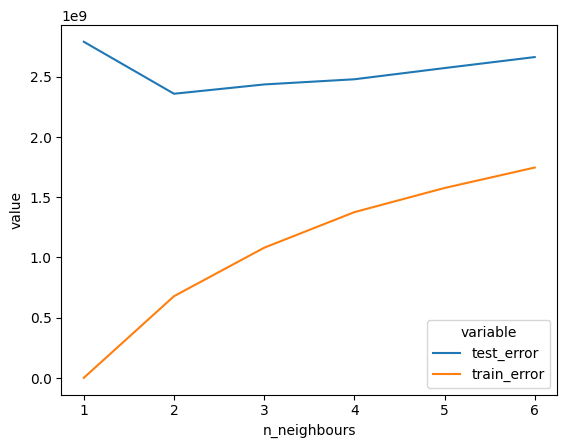

In [ ]:
loss_over_n = {"n_neighbours": [],"test_error" : [], "train_error": []}

size = 15000
for n in range(1, 7):
  loss_over_n["n_neighbours"].append(n)
  knn_model = KNeighborsRegressor(n_neighbors=n)
  knn_model.fit(X_train_pca[:size], y_train[:size])
  pred = knn_model.predict(X_test_pca)
  loss_over_n["test_error"].append(mean_squared_error(y_test, pred))

  pred_train = knn_model.predict(X_train_pca)
  loss_over_n["train_error"].append(mean_squared_error(y_train, pred_train))
  del knn_model

loss_over_n = pd.DataFrame(loss_over_n)
sns.lineplot(x='n_neighbours', y='value', hue='variable', 
             data=pd.melt(loss_over_n, ['n_neighbours']))

In [ ]:
loss_over_n

,n_neighbours,test_error,train_error
0,3,2.387424e+09,1.040108e+09
1,4,2.450119e+09,1.337333e+09
2,5,2.549251e+09,1.538011e+09
3,6,2.633950e+09,1.707656e+09
4,7,2.724971e+09,1.871614e+09
5,8,2.839514e+09,2.044452e+09
6,9,2.908493e+09,2.194747e+09


In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(X_train_pca, y_train)
print("model fitted")
pred = knn_model.predict(X_test_pca)
loss = mean_squared_error(y_test, pred)
print("squared loss {}".format(loss))
print("loss {}".format(loss**(1/2)))

r2 = r2_score(y_test, pred)
print("r2 {}".format(r2))

model fitted
squared loss 1710910555.7369287
loss 41363.15456704105
r2 0.9388095260239678


# Decision Tree Regressor

In [ ]:
# Task 4, Q6
tree_model = DecisionTreeRegressor()
param_grid = [{"criterion":["squared_error", "friedman_mse", "poisson"]}]
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.646055,3.469477,0.116164,0.018503,squared_error,{'criterion': 'squared_error'},-1.914528e+09,-1.889522e+09,-1.902783e+09,-1.850034e+09,-1.874069e+09,-1.886187e+09,2.255516e+07,2
1,5.917542,2.465198,0.063167,0.020500,friedman_mse,{'criterion': 'friedman_mse'},-1.890703e+09,-1.890890e+09,-1.906659e+09,-1.843442e+09,-1.896699e+09,-1.885679e+09,2.189970e+07,1
2,8.645226,0.458697,0.090944,0.032439,poisson,{'criterion': 'poisson'},-1.969202e+09,-1.874820e+09,-1.923379e+09,-1.823806e+09,-1.864434e+09,-1.891128e+09,5.029197e+07,3


In [ ]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
print("model fitted")
pred = tree_model.predict(X_test)
loss = mean_squared_error(y_test, pred)
print("squared loss {}".format(loss))
print("loss {}".format(loss**(1/2)))


r2 = r2_score(y_test, pred)
print("r2 {}".format(r2))

model fitted
squared loss 1781887189.1710582
loss 42212.40563117741
r2 0.9358614841366255


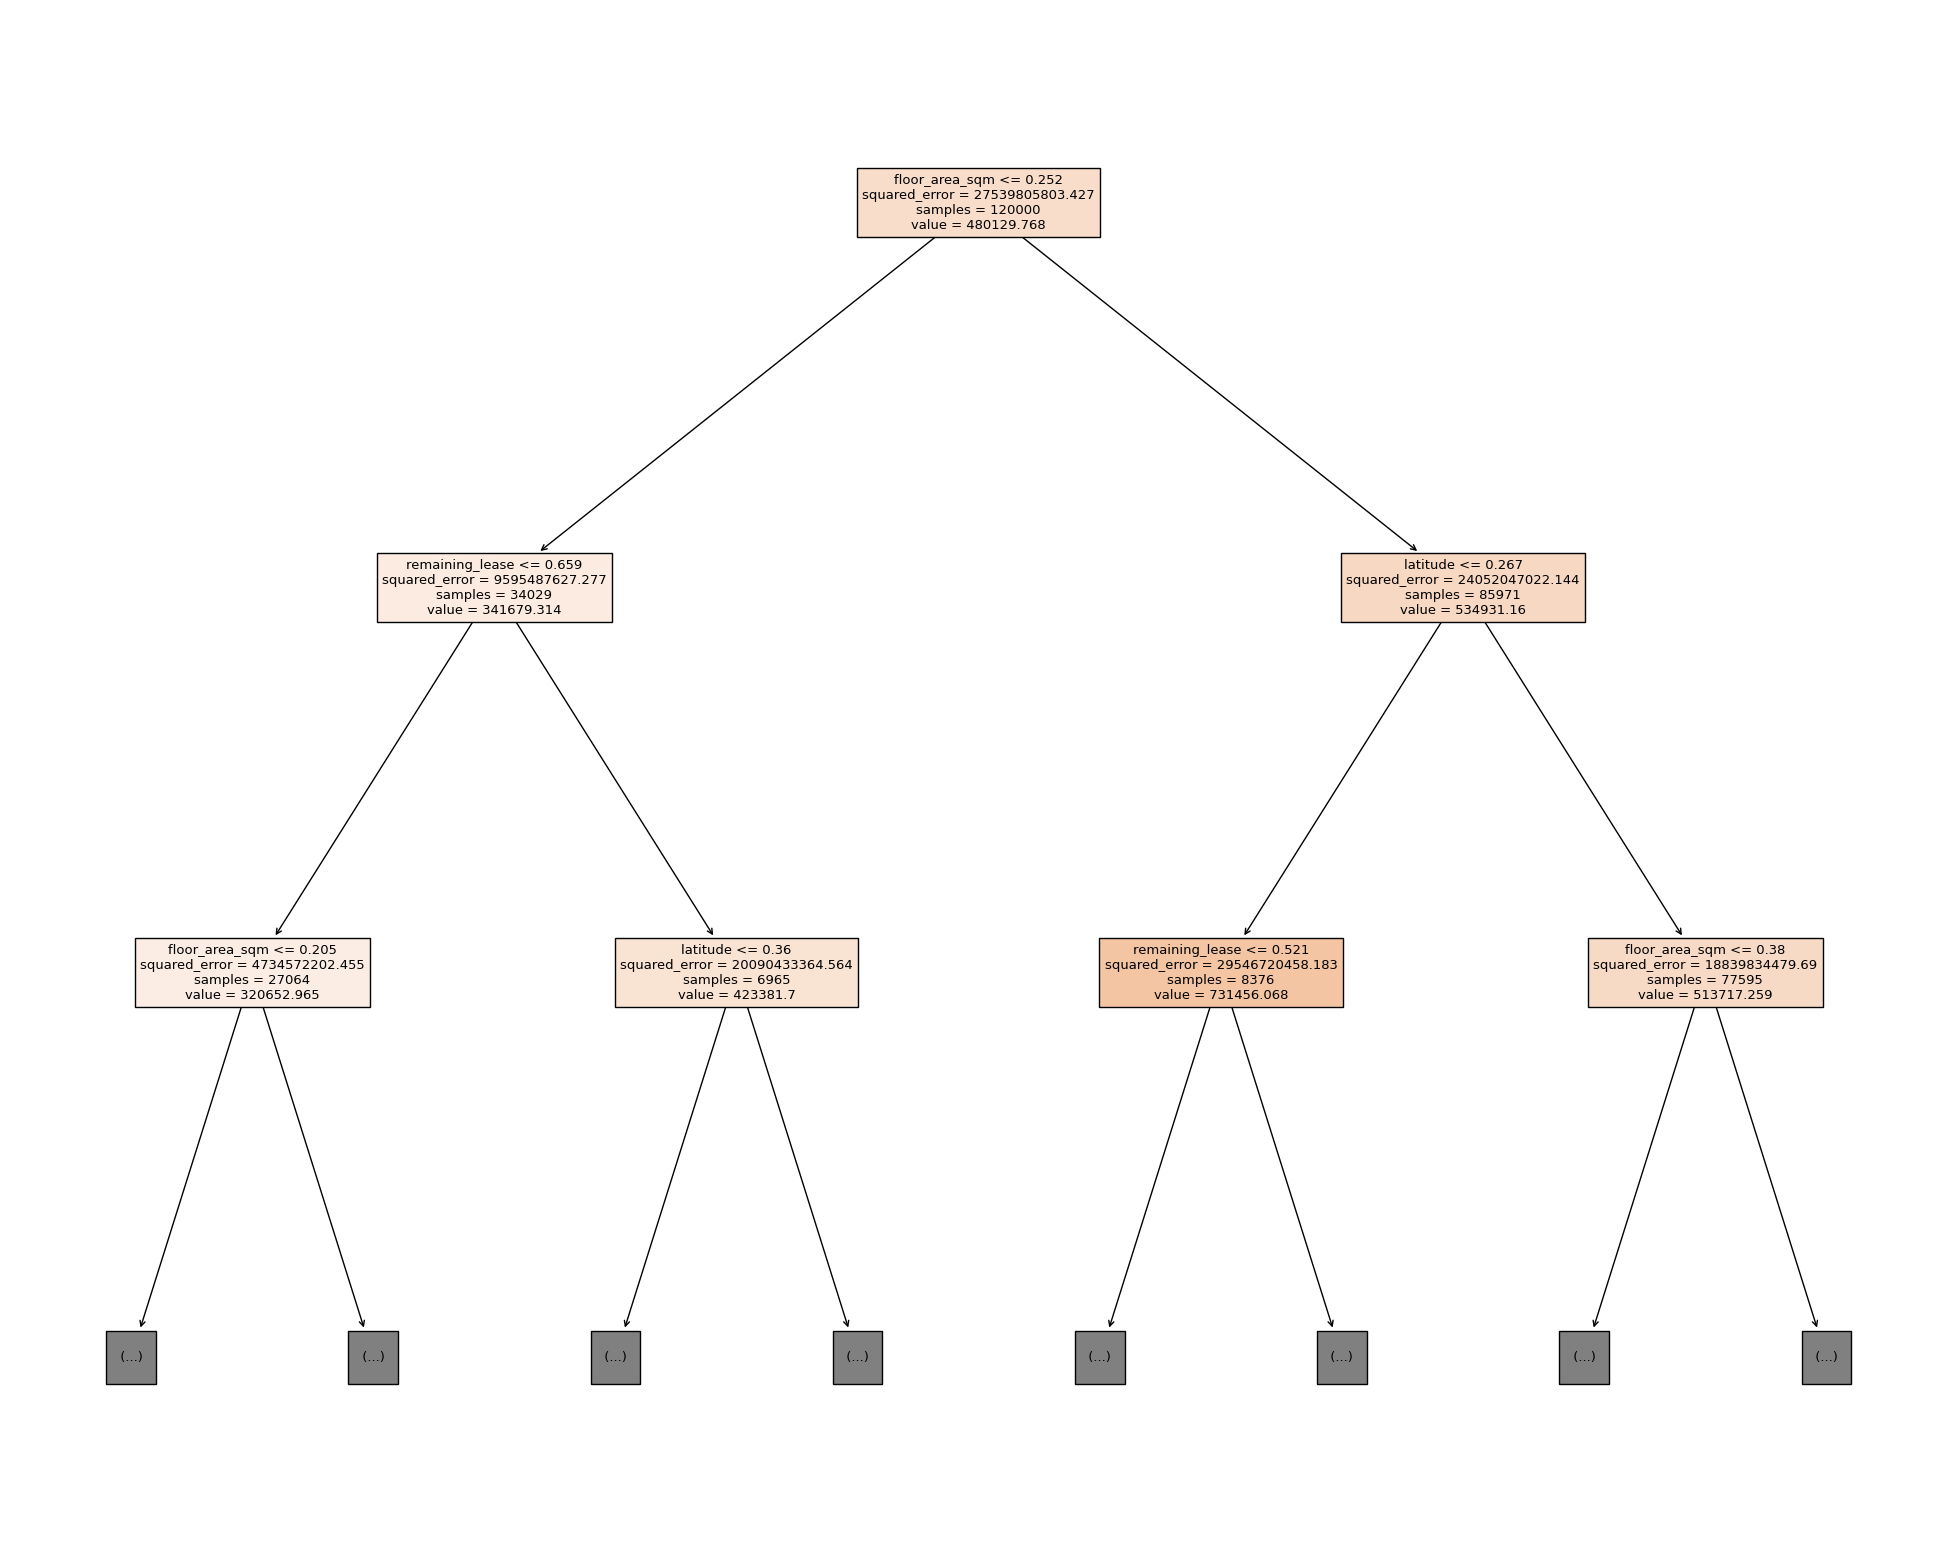

In [ ]:
fig = plt.figure(figsize=(25,20))
from sklearn import tree
_ = tree.plot_tree(tree_model, 
                   feature_names=X_test.columns,  
                   class_names=y_test["resale_price"],
                   filled=True,
                   max_depth=2)

# Linear Regression

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print("model fitted")
pred = linear_model.predict(X_test)
loss = mean_squared_error(y_test, pred)
print("squared loss {}".format(loss))
print("loss {}".format(loss**(1/2)))


r2 = r2_score(y_test, pred)
print("r2 {}".format(r2))

model fitted
squared loss 2856750751.772341
loss 53448.58044674658
r2 0.8978287135197183


In [ ]:
X_train.columns

Index(['floor_area_sqm', 'remaining_lease', 'latitude', 'longitude',
       'distance_to_nearest_mrt', 'resale_days_since_2017',
       'number_sold_in_same_town_month', 'town_BEDOK', 'town_BISHAN',
       'town_BUKIT BATOK',
       ...
       'nearest_mrt_TE15', 'nearest_mrt_TE16', 'nearest_mrt_TE18',
       'nearest_mrt_TE2', 'nearest_mrt_TE3', 'nearest_mrt_TE5',
       'nearest_mrt_TE6', 'nearest_mrt_TE7', 'nearest_mrt_TE8',
       'nearest_mrt_TE9'],
      dtype='object', length=219)

In [ ]:
pd.set_option('display.max_rows', 500)
a = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(linear_model.coef_))], axis = 1)
a.columns = ["feature", "cooeff"]
a["cooeff"] = a["cooeff"].astype(np.float32)
a

,feature,cooeff
0,floor_area_sqm,7.896828e+05
1,remaining_lease,2.979627e+05
2,latitude,5.935590e+04
3,longitude,-8.314097e+04
4,distance_to_nearest_mrt,-2.531078e+05
5,resale_days_since_2017,1.582453e+05
6,number_sold_in_same_town_month,-3.759385e+04
7,town_BEDOK,9.721185e+04
8,town_BISHAN,9.054789e+04
9,town_BUKIT BATOK,-2.466289e+15


# Neural Network

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, activation_fn):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(216, 20)
        self.fc2 = torch.nn.Linear(20, 1)
        self.activation = activation_fn
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


# Convert the pandas DataFrame to PyTorch tensors
train_X_ = torch.tensor(X_train.values, dtype=torch.float32)
train_y_ = torch.tensor(y_train.values, dtype=torch.float32)
test_X_ = torch.tensor(X_test.values, dtype=torch.float32)
test_y_ = torch.tensor(y_test.values, dtype=torch.float32)

# Set batch size and epochs
batch_size = 8192

In [ ]:
class NumericalPrediction(nn.Module):
    def __init__(self):
        super(NumericalPrediction, self).__init__()
        self.num_layers = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU())
        
        self.binary_layers = nn.Sequential(
            nn.Linear(211, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU())
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, numerical_inputs, binary_inputs):
        numerical_outputs = self.num_layers(numerical_inputs)
        binary_outputs = self.binary_layers(binary_inputs)
        concatenated_outputs = torch.cat((numerical_outputs, binary_outputs), dim=1)
        final_outputs = self.output_layer(concatenated_outputs)
        return final_outputs

train_X_numeric = torch.tensor(X_train[num_cols].values, dtype=torch.float32)
train_X_binary = torch.tensor(X_train.drop(num_cols, axis=1).values, dtype=torch.float32)
test_X_numeric = torch.tensor(X_test[num_cols].values, dtype=torch.float32)
test_X_binary = torch.tensor(X_test.drop(num_cols, axis=1).values, dtype=torch.float32)
train_y_ = torch.tensor(y_train.values, dtype=torch.float32)
test_y_ = torch.tensor(y_test.values, dtype=torch.float32)

# Set batch size and epochs
batch_size = 8192

In [ ]:
loss_over_n = {"Epoch": [],"test_error" : [], "train_error": []}
# We try different ones
activation_fn = torch.nn.ReLU()
# Instantiate the model
model = NumericalPrediction()
# try:
#   model.load_state_dict(torch.load('/content/drive/My Drive/IS3107/trained_model_relu_normalized.pt'))
# except:
#   model = Net(activation_fn)
# Define the loss function and optimizer
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
stop_counter = 0
epoch = 0
end = 100
while True:
  curr_loss = 0
  prev_loss = 999999999999999999999999999999999999999999
  prev_test_loss = 999999999999999999999999999999999999999999
  for i in range(0, len(train_X_), batch_size):
        optimizer.zero_grad()
        batch_X_numeric = train_X_numeric[i:i+batch_size]
        batch_X_binary = train_X_binary[i:i+batch_size]
        batch_y = train_y_[i:i+batch_size]
        outputs = model(batch_X_numeric, batch_X_binary)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        curr_loss += loss.item()
        optimizer.step()
  if epoch % 100 == 1:
    loss_over_n["n_neighbours"].append(epoch)
    with torch.no_grad():
      y_pred = model(test_X_numeric, test_X_binary)
      test_loss = loss_fn(test_y_, y_pred).item()
      loss_over_n["test_error"].append(test_loss)
      y_train_pred = model(train_X_numeric, train_X_binary)
      curr_loss = loss_fn(train_y_, y_train_pred).item()
      loss_over_n["train_error"].append(curr_loss)
    if test_loss < prev_test_loss * 0.95:
      prev_test_loss = test_loss
      # torch.save(model.state_dict(), '/content/drive/My Drive/IS3107/trained_model_relu_best_test.pt')
    else:
      end -= 1
      print("Test loss increasing at epoch {}".format(epoch))
      
  if end == 0:
    break
  if epoch % 1000 == 1:
    print("Epoch {},\t loss {}".format(epoch, curr_loss))
    # torch.save(model.state_dict(), '/content/drive/My Drive/IS3107/trained_model_relu_normalized.pt')
  stop_counter += 1
  if prev_loss > curr_loss:
    stop_counter = 0
  prev_loss = curr_loss
  epoch += 1
  if epoch > 15000:
    break
  if stop_counter >= 3:
    break
# Use the model to make predictions on test data
# y_pred = model(test_X_)
# print("final error,", mean_squared_error(test_y_, y_pred))

loss_over_n = pd.DataFrame(loss_over_n)
plt.figure()
sns.lineplot(x='Epoch', y='value', hue='variable', 
             data=pd.melt(loss_over_n, ['Epoch']))

In [ ]:
# activation_fn = torch.nn.ReLU()
# model = Net(activation_fn)
# model.load_state_dict(torch.load('/content/drive/My Drive/IS3107/trained_model_relu_normalized.pt'))

pred = model(test_X_numeric, test_X_binary).detach()
print(type(pred))
loss = mean_squared_error(test_y_, pred)
print("squared loss {}".format(loss))
print("loss {}".format(loss**(1/2)))


# sns.lineplot(x=loss_over_n['n_neighbours'], y=loss_over_n['train_error'])

In [ ]:
import joblib
scaler_filename = '/content/drive/My Drive/IS3107/advanced_multipart_model_processor.pt'

joblib.dump(norm, scaler_filename) 

# And now to load...

scaler = joblib.load('/content/drive/My Drive/IS3107/advanced_multipart_model_processor.pt')

In [ ]:

torch.save(model.state_dict(), '/content/drive/My Drive/IS3107/advanced_multipart_model.pt')

In [ ]:
norm

# Completed predictor for construction df

In [ ]:
import joblib
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


class NumericalPredictionConstruction(nn.Module):
    def __init__(self, a=64, a2=32, b=128, c=64):
        super(NumericalPredictionConstruction, self).__init__()
        self.num_layers = nn.Sequential(
            nn.Linear(8, a2),
            nn.ReLU(),
            )
        
        self.binary_layers = nn.Sequential(
            nn.Linear(165, c),
            nn.ReLU(),
            )
        self.output_layer = nn.Linear(a2+c, 1)
        
    def forward(self, numerical_inputs, binary_inputs):
        numerical_outputs = self.num_layers(numerical_inputs)
        binary_outputs = self.binary_layers(binary_inputs)
        concatenated_outputs = torch.cat((numerical_outputs, binary_outputs), dim=1)
        final_outputs = self.output_layer(concatenated_outputs)
        return final_outputs

file_dir = "/content/drive/My Drive/IS3107/ML-prediction" # Define file directory
construction_num_cols = ['flat_type', 'floor_area_sqm','remaining_lease', 'storey_range','latitude', 
                'longitude', 'distance_to_nearest_mrt', 'resale_days_since_2017']
                
construction_normalizer = dict()

for i in construction_num_cols:
    norm = joblib.load(file_dir + '/' + i + '-construction-normalizer-scaler.save') 
    construction_normalizer[file_dir + '/' + i + '-construction-normalizer-scaler.save'] = norm

construction_model = NumericalPredictionConstruction(a2=32, c=16)
construction_model.load_state_dict(torch.load(file_dir + '/construction-a2-32-c-16.pt'))

f = open(file_dir+"/construction_cols.txt", "r")
construction_cols_in_order = json.loads(f.read())["columns"]


def predict_construction(floor_area_sqm, remaining_lease, distance_to_nearest_mrt, 
                         resale_days_since_2017, flat_type, storey_range, latitude, 
                         longitude, flat_model, nearest_mrt, normalizer, model, cols_in_order, file_dir=file_dir, multi_pred=False, ):

    num_cols = ['flat_type', 'floor_area_sqm','remaining_lease', 'storey_range','latitude', 'longitude', 'distance_to_nearest_mrt', 'resale_days_since_2017',]

    # flat_type	floor_area_sqm	remaining_lease	storey_range	latitude	longitude	distance_to_nearest_mrt	resale_days_since_2017
    
    if multi_pred:
        df = pd.DataFrame({'flat_type':flat_type, 'floor_area_sqm':floor_area_sqm,'remaining_lease':remaining_lease,'storey_range':storey_range, 'latitude':latitude, 'longitude':longitude, 'distance_to_nearest_mrt':distance_to_nearest_mrt, 'resale_days_since_2017':resale_days_since_2017, 
                    "flat_model":flat_model, "nearest_mrt":nearest_mrt})
    else:
        df = pd.DataFrame({'flat_type':flat_type, 'floor_area_sqm':floor_area_sqm,'remaining_lease':remaining_lease,'storey_range':storey_range, 'latitude':latitude, 'longitude':longitude, 'distance_to_nearest_mrt':distance_to_nearest_mrt, 'resale_days_since_2017':resale_days_since_2017, 
                    "flat_model":flat_model, "nearest_mrt":nearest_mrt}, index=[0])

    # print("1.---------------------------------------\n",df.loc[:, (df[0:1] != 0).any()][0:1])

    for category in ["flat_model", "nearest_mrt"]:
        encoded = pd.get_dummies(df[[category]])
        df = pd.concat([df.drop([category], axis=1),encoded], axis=1)
        del encoded

    for col in cols_in_order:
        if col not in df:
            df[col] = 0

    # print("3.---------------------------------------\n",df.loc[:, (df[0:1] != 0).any()][0:1])

    for i in num_cols:
        norm = normalizer[file_dir + '/' + i + '-construction-normalizer-scaler.save']
        # transform the training data column
        df[i] = norm.transform(df[[i]])

    df = df[cols_in_order]

    # print("4.---------------------------------------\n",df.loc[:, (df[0:1] != 0).any()][0:1])

    con_X_num = torch.tensor(df[num_cols].values, dtype=torch.float32)
    con_X_bin = torch.tensor(df.drop(num_cols, axis=1).values, dtype=torch.float32)

    pred = model(con_X_num, con_X_bin).detach().numpy()
    return pd.DataFrame(pred.reshape([-1,1]), columns=["resale_price"])

predict_construction(flat_type=2, flat_model="Improved", 
        floor_area_sqm=44.0, remaining_lease=736, storey_range=4, 
        latitude=1.362005, longitude=103.853882, nearest_mrt="NS16",
        distance_to_nearest_mrt=0.999941, resale_days_since_2017=0, normalizer=construction_normalizer, 
        model=construction_model, cols_in_order=construction_cols_in_order, file_dir=file_dir, multi_pred=False)

# predict_construction(flat_type=3, flat_model="New Generation", 
#                         floor_area_sqm=68.0, remaining_lease=744, storey_range=2, 
#                         latitude=1.366201, longitude=103.857201, nearest_mrt="TE6",
#                         distance_to_nearest_mrt=0.945375, resale_days_since_2017=0)

# predict_construction(flat_type=6, flat_model="Maisonette", 
#                         floor_area_sqm=146.0, remaining_lease=761, storey_range=4, 
#                         latitude=1.420500	, longitude=103.832375, nearest_mrt="NS14",
#                         distance_to_nearest_mrt=0.351151, resale_days_since_2017=2250)

# predict_construction(flat_type=6, flat_model="Apartment", 
#                         floor_area_sqm=164.0, remaining_lease=819, storey_range=1, 
#                         latitude=1.421062, longitude=103.838806, nearest_mrt="NS14",
#                         distance_to_nearest_mrt=0.765432, resale_days_since_2017=2250)


# mse = mean_squared_error(df[["resale_price"]],pred)
# print("mse: {}, mae: {}".format(mse, np.sqrt(mse)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,resale_price
0,307713.28125


# Completed Predictor for resale

In [ ]:
import joblib
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

class NumericalPredictionResale(nn.Module):
    def __init__(self, a=64, a2=32, b=128, c=16):
        super(NumericalPredictionResale, self).__init__()
        self.num_layers = nn.Sequential(
            nn.Linear(9, a2),
            nn.ReLU(),
            # nn.Linear(a, a2),
            # nn.ReLU(),
            )
        
        self.binary_layers = nn.Sequential(
            nn.Linear(190, c),
            nn.ReLU(),
            # nn.Linear(b, c),
            # nn.ReLU()
            )
        self.output_layer = nn.Linear(a2+c, 1)
        
    def forward(self, numerical_inputs, binary_inputs):
        numerical_outputs = self.num_layers(numerical_inputs)
        binary_outputs = self.binary_layers(binary_inputs)
        concatenated_outputs = torch.cat((numerical_outputs, binary_outputs), dim=1)
        final_outputs = self.output_layer(concatenated_outputs)
        return final_outputs

file_dir = "/content/drive/My Drive/IS3107/ML-prediction" # Define file directory
resale_num_cols = ['flat_type', 'floor_area_sqm','remaining_lease', 'storey_range','latitude', 
                'longitude', 'distance_to_nearest_mrt', 'resale_days_since_2017',
                "number_sold_around_same_mrt_for_month"]

resale_normalizer = dict()

for i in resale_num_cols:
    norm = joblib.load(file_dir + '/' + i + '-resale-normalizer-scaler.save') 
    resale_normalizer[file_dir + '/' + i + '-resale-normalizer-scaler.save'] = norm

resale_model = NumericalPredictionResale(a2=32, c=16)
resale_model.load_state_dict(torch.load(file_dir + '/resale-a2-32-c-16.pt'))

f = open(file_dir+"/resale_cols.txt", "r")
resale_cols_in_order = json.loads(f.read())["columns"]

def predict_resale(town, flat_type, flat_model, 
                         floor_area_sqm, remaining_lease, storey_range, latitude, longitude, 
                          nearest_mrt, distance_to_nearest_mrt, resale_days_since_2017,
                         number_sold_around_same_mrt_for_month, normalizer, model, cols_in_order, file_dir=file_dir, multi_pred=False, ):

    num_cols = ['flat_type', 'floor_area_sqm','remaining_lease', 'storey_range','latitude', 
                'longitude', 'distance_to_nearest_mrt', 'resale_days_since_2017',
                "number_sold_around_same_mrt_for_month"]

    if multi_pred:
        df = pd.DataFrame({'town':town, 'flat_type':flat_type, 'floor_area_sqm':floor_area_sqm,'remaining_lease':remaining_lease,
                        'storey_range':storey_range, 'latitude':latitude, 'longitude':longitude, 
                        'distance_to_nearest_mrt':distance_to_nearest_mrt, 'resale_days_since_2017':resale_days_since_2017, 
                        "flat_model":flat_model, "nearest_mrt":nearest_mrt, 
                        "number_sold_around_same_mrt_for_month":number_sold_around_same_mrt_for_month})
    else:
        df = pd.DataFrame({'town':town, 'flat_type':flat_type, 'floor_area_sqm':floor_area_sqm,'remaining_lease':remaining_lease,
                        'storey_range':storey_range, 'latitude':latitude, 'longitude':longitude, 
                        'distance_to_nearest_mrt':distance_to_nearest_mrt, 'resale_days_since_2017':resale_days_since_2017, 
                        "flat_model":flat_model, "nearest_mrt":nearest_mrt, 
                        "number_sold_around_same_mrt_for_month":number_sold_around_same_mrt_for_month}, index=[0])

    for category in ["town", "flat_model", "nearest_mrt"]:
        encoded = pd.get_dummies(df[[category]])
        df = pd.concat([df.drop([category], axis=1),encoded], axis=1)
        del encoded

    for col in cols_in_order:
        if col not in df:
            df[col] = 0

    for i in num_cols:
        norm = normalizer[file_dir + '/' + i + '-resale-normalizer-scaler.save'] 
        # transform the training data column
        df[i] = norm.transform(df[[i]])

    df = df[cols_in_order]
    
    con_X_num = torch.tensor(df[num_cols].values, dtype=torch.float32)
    con_X_bin = torch.tensor(df.drop(num_cols, axis=1).values, dtype=torch.float32)


    pred = model(con_X_num, con_X_bin).detach().numpy()
    return pd.DataFrame(pred.reshape([-1,1]), columns=["resale_price"])

predict_resale(town="ANG MO KIO", flat_type=2, flat_model="Improved", 
               floor_area_sqm=44.0, remaining_lease=736, storey_range=4, 
               latitude=1.362005, longitude=103.853882, nearest_mrt="NS16",
               distance_to_nearest_mrt=0.999941, resale_days_since_2017=0, 
               number_sold_around_same_mrt_for_month=34, normalizer=resale_normalizer, model=resale_model, file_dir=file_dir, cols_in_order=resale_cols_in_order)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,resale_price
0,305099.4375


# Predict multiple rows

In [ ]:
def preprocess_df(df):
    df["remaining_lease"] = df["remaining_lease"].str.findall(r'\d+ years').str[0].str.findall(r'\d+').str[0].fillna(0).astype(int) * 12 \
            + df["remaining_lease"].str.findall(r'\d+ months').str[0].str.findall(r'\d+').str[0].fillna(0).astype(int)
    df["distance_to_nearest_mrt"] = df["distance_to_nearest_mrt"].str.findall(r'\d+.\d+').str[0].fillna(0).astype(np.float32)
    df["latitude"] = df["latitude"].astype(np.float32)
    df["longitude"] = df["longitude"].astype(np.float32)
    df["resale_days_since_2017"] = (pd.to_datetime(df["month"], format="%Y-%m") - pd.to_datetime("2017-01-01")).dt.days
    df = df.drop(["month"], axis=1)

    aggregate_result=pd.DataFrame({'number_sold_around_same_mrt_for_month':df.groupby(["nearest_mrt","resale_days_since_2017"])[['nearest_mrt','resale_days_since_2017']].size()}).reset_index()
    df = df.merge(aggregate_result, on=["nearest_mrt","resale_days_since_2017"])

    # Label encode df
    df.loc[df["storey_range"]=='01 TO 03', "storey_range"] = 1
    df.loc[df["storey_range"]=='04 TO 06', "storey_range"] = 2
    df.loc[df["storey_range"]=='07 TO 09', "storey_range"] = 3
    df.loc[df["storey_range"]=='10 TO 12', "storey_range"] = 4
    df.loc[df["storey_range"]=='13 TO 15', "storey_range"] = 5
    df.loc[df["storey_range"]=='16 TO 18', "storey_range"] = 6
    df.loc[df["storey_range"]=='19 TO 21', "storey_range"] = 7
    df.loc[df["storey_range"]=='22 TO 24', "storey_range"] = 8
    df.loc[df["storey_range"]=='25 TO 27', "storey_range"] = 9
    df.loc[df["storey_range"]=='28 TO 30', "storey_range"] = 10
    df.loc[df["storey_range"]=='31 TO 33', "storey_range"] = 11
    df.loc[df["storey_range"]=='34 TO 36', "storey_range"] = 12
    df.loc[df["storey_range"]=='37 TO 39', "storey_range"] = 13
    df.loc[df["storey_range"]=='40 TO 42', "storey_range"] = 14
    df.loc[df["storey_range"]=='43 TO 45', "storey_range"] = 15
    df.loc[df["storey_range"]=='46 TO 48', "storey_range"] = 16
    df.loc[df["storey_range"]=='49 TO 51', "storey_range"] = 17
    df.loc[:,"storey_range"] = df[["storey_range"]].astype(int)

    df.loc[df["flat_type"]=='1 ROOM', "flat_type"] = 1
    df.loc[df["flat_type"]=='2 ROOM', "flat_type"] = 2
    df.loc[df["flat_type"]=='3 ROOM', "flat_type"] = 3
    df.loc[df["flat_type"]=='4 ROOM', "flat_type"] = 4
    df.loc[df["flat_type"]=='5 ROOM', "flat_type"] = 5
    df.loc[df["flat_type"]=='EXECUTIVE', "flat_type"] = 6
    df.loc[df["flat_type"]=='MULTI-GENERATION', "flat_type"] = 7
    df.loc[:,"flat_type"] = df[["flat_type"]].astype(int)
    return df
    
df = preprocess_df(pd.read_csv("/content/drive/My Drive/IS3107/closest_mrt_df.csv"))


# construction_pred = predict_construction(flat_type=df["flat_type"], flat_model=df["flat_model"], 
#                         floor_area_sqm=df["floor_area_sqm"], remaining_lease=df["remaining_lease"], storey_range=df["storey_range"], 
#                         latitude=df["latitude"], longitude=df["longitude"], nearest_mrt=df["nearest_mrt"],
#                         distance_to_nearest_mrt=df["distance_to_nearest_mrt"], resale_days_since_2017=df["resale_days_since_2017"], multi_pred=True)

resale_pred = predict_resale(town=df["town"], flat_type=df["flat_type"], flat_model=df["flat_model"], 
                        floor_area_sqm=df["floor_area_sqm"], remaining_lease=df["remaining_lease"], storey_range=df["storey_range"], 
                        latitude=df["latitude"], longitude=df["longitude"], nearest_mrt=df["nearest_mrt"],
                        distance_to_nearest_mrt=df["distance_to_nearest_mrt"], resale_days_since_2017=df["resale_days_since_2017"], 
                        number_sold_around_same_mrt_for_month=df["number_sold_around_same_mrt_for_month"], 
                        normalizer=resale_normalizer, model=resale_model, file_dir=file_dir, cols_in_order=resale_cols_in_order,multi_pred=True)

<ipython-input-18-6923bc385315>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,"storey_range"] = df[["storey_range"]].astype(int)
<ipython-input-18-6923bc385315>:40: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,"flat_type"] = df[["flat_type"]].astype(int)


In [ ]:
from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error for construction predictor {}".format(mean_absolute_error(df["resale_price"], construction_pred)) )
print("Mean Absolute Error for resale predictor {}\n\n".format(mean_absolute_error(df["resale_price"], resale_pred)))
print("R-squared for resale predictor {}\n\n".format(r2_score(df["resale_price"], resale_pred)))

# print(construction_pred.rename({"resale_price":"Construction model predicted"}, axis='columns'))
# print(resale_pred.rename({"resale_price":"Resale model predicted"}, axis='columns'))
# print(df["resale_price"])

Mean Absolute Error for resale predictor 24986.09760695417


R-squared for resale predictor 0.9578342959212144




In [ ]:
resale_pred

,resale_price
0,305099.50000
1,293611.75000
2,295138.68750
3,295138.68750
4,287868.34375
...,...
149995,699767.12500
149996,572580.68750
149997,627521.68750
149998,847717.81250


# Model Training

In [ ]:
def preprocess_df(df):
    df["remaining_lease"] = df["remaining_lease"].str.findall(r'\d+ years').str[0].str.findall(r'\d+').str[0].fillna(0).astype(int) * 12 \
            + df["remaining_lease"].str.findall(r'\d+ months').str[0].str.findall(r'\d+').str[0].fillna(0).astype(int)
    df["distance_to_nearest_mrt"] = df["distance_to_nearest_mrt"].str.findall(r'\d+.\d+').str[0].fillna(0).astype(np.float32)
    df["latitude"] = df["latitude"].astype(np.float32)
    df["longitude"] = df["longitude"].astype(np.float32)
    df["resale_days_since_2017"] = (pd.to_datetime(df["month"], format="%Y-%m") - pd.to_datetime("2017-01-01")).dt.days
    df = df.drop(["month"], axis=1)

    aggregate_result=pd.DataFrame({'number_sold_around_same_mrt_for_month':df.groupby(["nearest_mrt","resale_days_since_2017"])[['nearest_mrt','resale_days_since_2017']].size()}).reset_index()
    df = df.merge(aggregate_result, on=["nearest_mrt","resale_days_since_2017"])

    # Label encode df
    df.loc[df["storey_range"]=='01 TO 03', "storey_range"] = 1
    df.loc[df["storey_range"]=='04 TO 06', "storey_range"] = 2
    df.loc[df["storey_range"]=='07 TO 09', "storey_range"] = 3
    df.loc[df["storey_range"]=='10 TO 12', "storey_range"] = 4
    df.loc[df["storey_range"]=='13 TO 15', "storey_range"] = 5
    df.loc[df["storey_range"]=='16 TO 18', "storey_range"] = 6
    df.loc[df["storey_range"]=='19 TO 21', "storey_range"] = 7
    df.loc[df["storey_range"]=='22 TO 24', "storey_range"] = 8
    df.loc[df["storey_range"]=='25 TO 27', "storey_range"] = 9
    df.loc[df["storey_range"]=='28 TO 30', "storey_range"] = 10
    df.loc[df["storey_range"]=='31 TO 33', "storey_range"] = 11
    df.loc[df["storey_range"]=='34 TO 36', "storey_range"] = 12
    df.loc[df["storey_range"]=='37 TO 39', "storey_range"] = 13
    df.loc[df["storey_range"]=='40 TO 42', "storey_range"] = 14
    df.loc[df["storey_range"]=='43 TO 45', "storey_range"] = 15
    df.loc[df["storey_range"]=='46 TO 48', "storey_range"] = 16
    df.loc[df["storey_range"]=='49 TO 51', "storey_range"] = 17
    df.loc[:,"storey_range"] = df[["storey_range"]].astype(int)

    df.loc[df["flat_type"]=='1 ROOM', "flat_type"] = 1
    df.loc[df["flat_type"]=='2 ROOM', "flat_type"] = 2
    df.loc[df["flat_type"]=='3 ROOM', "flat_type"] = 3
    df.loc[df["flat_type"]=='4 ROOM', "flat_type"] = 4
    df.loc[df["flat_type"]=='5 ROOM', "flat_type"] = 5
    df.loc[df["flat_type"]=='EXECUTIVE', "flat_type"] = 6
    df.loc[df["flat_type"]=='MULTI-GENERATION', "flat_type"] = 7
    df.loc[:,"flat_type"] = df[["flat_type"]].astype(int)
    return df

In [ ]:
# Common Libraries needed
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time
import random
import urllib
import json
import torch
import torch.nn as nn
import geopy.distance
from math import dist
from geopy.distance import geodesic as GD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from io import StringIO
from pandas import json_normalize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

from google.colab import drive

drive.mount('/content/drive')

df = preprocess_df( pd.read_csv("/content/drive/My Drive/IS3107/closest_mrt_df.csv") )


y              = df[["resale_price"]]

construction_X = df[[        "flat_type", "flat_model", "floor_area_sqm", "remaining_lease", 
               "storey_range", "latitude", "longitude", "nearest_mrt", "distance_to_nearest_mrt", "resale_days_since_2017"]].copy()

resale_X       = df[["town", "flat_type", "flat_model", "floor_area_sqm", "remaining_lease", 
               "storey_range", "latitude", "longitude", "nearest_mrt", "distance_to_nearest_mrt", "resale_days_since_2017", "number_sold_around_same_mrt_for_month"]].copy()

# Encode construction_X
for category in ["flat_model", "nearest_mrt"]:
  encoded = pd.get_dummies(construction_X[[category]], drop_first=True)
  construction_X = pd.concat([construction_X.drop([category], axis=1),encoded], axis=1)
  del encoded

# Encode resale_X
for category in ["town", "flat_model", "nearest_mrt"]:
  encoded = pd.get_dummies(resale_X[[category]], drop_first=True)
  resale_X = pd.concat([resale_X.drop([category], axis=1),encoded], axis=1)
  del encoded


# Saves new fitted preprocessing Normalizer
def split_normalize(X, y, num_cols, test_size=0.2, dataFrame_name="construction"):
    file_dir = "/content/drive/My Drive/IS3107/ML-prediction" # Define file directory

    normalization_or_standardize = "normalizer"
    resale_X_train, resale_X_test, resale_y_train, resale_y_test = train_test_split(X, y, test_size=test_size)
    
    if normalization_or_standardize == "standardize":
    # numerical features
    # apply standardization on numerical features
        for i in num_cols:
            # fit on training data column
            scale = StandardScaler().fit(resale_X_train[[i]])
            # transform the training data column
            resale_X_train[i] = scale.transform(resale_X_train[[i]])
            # transform the testing data column
            resale_X_test[i] = scale.transform(resale_X_test[[i]])
            
            import joblib
            joblib.dump(scale, file_dir + '/'+ i + '-'+ dataFrame_name +'-standardize-scaler.save') 
            

    elif normalization_or_standardize == "normalizer":
        for i in num_cols:
            # fit on training data column
            norm = MinMaxScaler().fit(resale_X_train[[i]])
            # transform the training data column
            resale_X_train[i] = norm.transform(resale_X_train[[i]])
            # transform the testing data column
            resale_X_test[i] = norm.transform(resale_X_test[[i]])

            
            import joblib
            joblib.dump(norm, file_dir + '/'+ i + '-'+dataFrame_name+'-normalizer-scaler.save') 

    f = open(file_dir+"/"+dataFrame_name+"_cols.txt", "r")
    cols_in_oder = json.loads(f.read())["columns"]
    for col in cols_in_oder:
        if col not in resale_X_train:
            resale_X_train[col] = 0
        if col not in resale_X_test:
            resale_X_test[col] = 0
    resale_X_test = resale_X_test[cols_in_oder]
    resale_X_train = resale_X_train[cols_in_oder]

    train_X_numeric = torch.tensor(resale_X_train[num_cols].values, dtype=torch.float32)
    train_X_binary = torch.tensor(resale_X_train.drop(num_cols, axis=1).values, dtype=torch.float32)
    test_X_numeric = torch.tensor(resale_X_test[num_cols].values, dtype=torch.float32)
    test_X_binary = torch.tensor(resale_X_test.drop(num_cols, axis=1).values, dtype=torch.float32)
    train_y_ = torch.tensor(resale_y_train.values, dtype=torch.float32)
    test_y_ = torch.tensor(resale_y_test.values, dtype=torch.float32)
    return train_X_numeric, train_X_binary, test_X_numeric, test_X_binary, train_y_, test_y_

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-22194ad924e5>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,"storey_range"] = df[["storey_range"]].astype(int)
<ipython-input-2-22194ad924e5>:40: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,"flat_type"] = df[["flat_type"]].astype(int)


In [ ]:
def train_model_plot(model, 
                     train_X_numeric, train_X_binary, train_y_, 
                     test_X_numeric, test_X_binary, test_y_,
                     max_epoch = 100, skip_plot = False, batch_size=256, verbose = True, early_stopping = 3):
    time_tester = time.perf_counter()
    loss_over_n = {"Epoch": [], "test_error" : [], "train_error": []}
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

    # Train the model
    # TIME_LIMIT = 9999
    stop_counter = 0
    epoch = 9999999999999
    end = early_stopping

    if not skip_plot:
        with torch.no_grad():
                # loss_over_n["Epoch"].append(0)
                y_pred = model(test_X_numeric, test_X_binary)
                test_loss = loss_fn(test_y_, y_pred).item()
                print("Initial test error ", test_loss)
                # loss_over_n["test_error"].append(test_loss)

                y_train_pred = model(train_X_numeric, train_X_binary)
                train_loss = loss_fn(train_y_, y_train_pred).item()
                print("Initial training error ", train_loss)
                # loss_over_n["train_error"].append(train_loss)
    # time_limit = time.perf_counter()

    
    prev_loss = 999999999999999999999999999999999999999999
    prev_test_loss = 999999999999999999999999999999999999999999
    while True:
        curr_loss = 0
        
        # if time.perf_counter() - time_limit > TIME_LIMIT:
        #     break
        for i in range(0, len(train_X_numeric), batch_size):
                optimizer.zero_grad()

                batch_X_training_dat = train_X_numeric[i:i+batch_size]
                batch_X_training_img_dat = train_X_binary[i:i+batch_size]
                batch_y_training_dat = train_y_[i:i+batch_size]

                outputs = model(batch_X_training_dat, batch_X_training_img_dat)
                loss = loss_fn(outputs, batch_y_training_dat)
                loss.backward()
                curr_loss += loss.item()
                optimizer.step()
                # if time.perf_counter() - time_limit > TIME_LIMIT:
                #     break

        if not skip_plot:
            with torch.no_grad():
                    loss_over_n["Epoch"].append(epoch)
                    y_pred = model(test_X_numeric, test_X_binary)
                    test_loss = loss_fn(test_y_, y_pred).item()
                    loss_over_n["test_error"].append(test_loss)

                    y_train_pred = model(train_X_numeric, train_X_binary)
                    train_loss = loss_fn(train_y_, y_train_pred).item()
                    loss_over_n["train_error"].append(train_loss)
                    if test_loss < prev_test_loss:
                        prev_test_loss = test_loss
                        end = early_stopping
                    else:
                        end -= 1
                        if verbose:
                            print("Test loss not dropping at epoch {}".format(epoch))
                    if end == 0:
                        break
        if verbose and epoch % 250 == 0:
            print("Epoch {}  :\t loss {}".format(epoch, curr_loss))

        stop_counter += 1
        if prev_loss > curr_loss:
            stop_counter = 0
            prev_loss = curr_loss
        epoch += 1
        if epoch >= max_epoch:
            break
        if stop_counter >= 3:
            break
    # Use the model to make predictions on test data
    # y_pred = model(test_X_)
    # print("final error,", mean_squared_error(test_y_, y_pred))

    if not skip_plot:
        import seaborn as sns
        plt.figure()
        loss_over_n = pd.DataFrame(loss_over_n)
        sns.lineplot(x='Epoch', y='value', hue='variable', 
                    data=pd.melt(loss_over_n, ['Epoch']))
    if verbose:
        print("Time used for model training: {}".format(time.perf_counter() - time_tester))
    return model   

class NumericalPredictionConstruction(nn.Module):
    def __init__(self, a=64, a2=32, b=128, c=64):
        super(NumericalPredictionConstruction, self).__init__()
        self.num_layers = nn.Sequential(
            nn.Linear(8, a2),
            nn.ReLU(),
            )
        
        self.binary_layers = nn.Sequential(
            nn.Linear(165, c),
            nn.ReLU(),
            )
        self.output_layer = nn.Linear(a2+c, 1)
        
    def forward(self, numerical_inputs, binary_inputs):
        numerical_outputs = self.num_layers(numerical_inputs)
        binary_outputs = self.binary_layers(binary_inputs)
        concatenated_outputs = torch.cat((numerical_outputs, binary_outputs), dim=1)
        final_outputs = self.output_layer(concatenated_outputs)
        return final_outputs
        
class NumericalPredictionResale(nn.Module):
    def __init__(self, a=64, a2=32, b=128, c=64):
        super(NumericalPredictionResale, self).__init__()
        self.num_layers = nn.Sequential(
            nn.Linear(9, a2),
            nn.ReLU(),
            )
        
        self.binary_layers = nn.Sequential(
            nn.Linear(190, c),
            nn.ReLU(),
            )
        self.output_layer = nn.Linear(a2+c, 1)
        
    def forward(self, numerical_inputs, binary_inputs):
        numerical_outputs = self.num_layers(numerical_inputs)
        binary_outputs = self.binary_layers(binary_inputs)
        concatenated_outputs = torch.cat((numerical_outputs, binary_outputs), dim=1)
        final_outputs = self.output_layer(concatenated_outputs)
        return final_outputs


Initial test error  258213117952.0
Initial training error  258036121600.0
Epoch 250  :	 loss 289251786752.0
Epoch 500  :	 loss 62170726400.0
Epoch 750  :	 loss 37972924416.0
Time used for model training: 164.430665461
Time taken to predict values: 0.01333377599985397
Final average scores :

MSE: {0: [16391778000.0]}
time taken:

{
  "0": [
    164.44668361599997
  ]
}


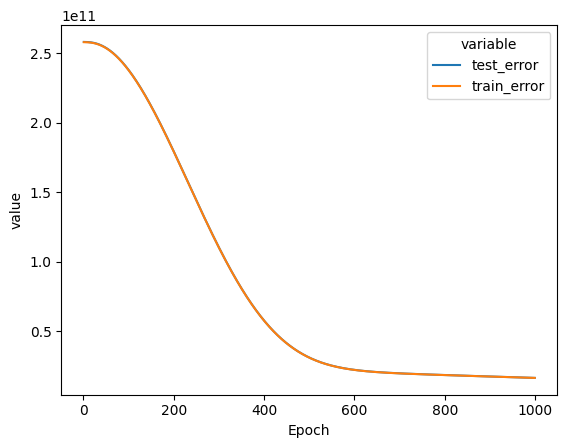

In [ ]:
hypers = [
    {"a":0, "a2":32, "b":0, "c":16},
    {"a":0, "a2":16, "b":0, "c":32},
    {"a":0, "a2":32, "b":0, "c":32},
    {"a":0, "a2":16, "b":0, "c":16},
    {"a":0, "a2":64, "b":0, "c":64},
]

mse = dict()
tim_keeper = dict()
NUM_TEST = 1
epoch = 1000

for i in range(NUM_TEST):
    # Split train and test

    train_X_numeric, train_X_binary, test_X_numeric, test_X_binary, train_y_, test_y_ = split_normalize(construction_X, y, 
        num_cols=['flat_type', 'floor_area_sqm','remaining_lease', 'storey_range','latitude', 'longitude', 'distance_to_nearest_mrt', 'resale_days_since_2017',],
        dataFrame_name="construction")

    a=[]
    d=[]

    for combi in hypers:
        start = time.perf_counter()

        # Train and predict
        model = NumericalPredictionConstruction(**combi)

        model = train_model_plot(model, 
                            train_X_numeric, train_X_binary, train_y_, 
                            test_X_numeric, test_X_binary, test_y_,
                            max_epoch = epoch, skip_plot = False, batch_size=65536, verbose = True)
        
        torch.save(model.state_dict(), '/content/drive/My Drive/IS3107/construction-a2-'+str(combi["a2"])+'-c-'+str(combi["c"])+'.pt')

        predict_timer = time.perf_counter()
        y_pred = model(test_X_numeric, test_X_binary).detach().numpy()
        # Evaluate model predition (TODO: uncomment the appropriate ones)
        # Learn more: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
        # print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_pred)))
        # print("Precision is {0:.2f}".format(precision_score(y_test, y_pred)))
        # print("Recall is {0:.2f}".format(recall_score(y_test, y_pred)))
        # print("F1 Score is {0:.2f}".format(f1_score(y_test, y_pred)))
        a1 = mean_squared_error(test_y_, y_pred)
        a.append(a1)
        d.append(time.perf_counter()-start)
        print("Time taken to predict values: {}".format(time.perf_counter() - predict_timer))
    
    mse[i] = a
    tim_keeper[i] = d

    print("Final average scores :\n\nMSE: {}".format(mse))
    print("time taken:\n\n" + json.dumps(tim_keeper, indent=2))

# models = []
# for i in range(len(mse[0])):
#     summ = 0
#     for k in range(NUM_TEST):
#         summ += mse[k][i]
#     models.append(summ/NUM_TEST)
# import seaborn as sns
# plt.figure()
# sns.lineplot(models, list(range(len(mse[0]))))

Initial test error  257142865920.0
Initial training error  258303885312.0
Epoch 250  :	 loss 251572412416.0
Epoch 500  :	 loss 50615822336.0
Epoch 750  :	 loss 36993021952.0
Time used for model training: 188.84491457100012
Time taken to predict values: 0.018041237000034016
Final average scores :

MSE: {0: [15312397000.0]}
time taken:

{
  "0": [
    188.86517593700046
  ]
}


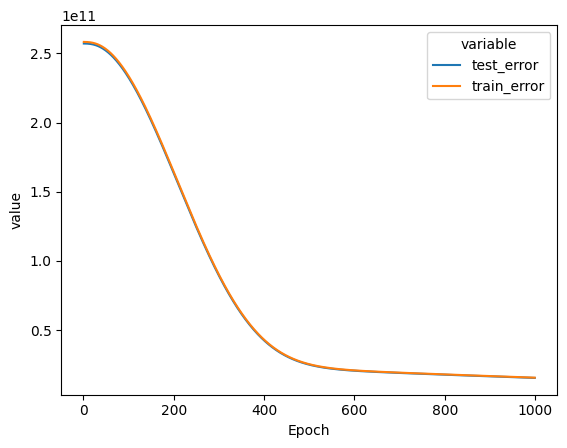

In [ ]:
hypers = [
    {"a":0, "a2":32, "b":0, "c":16},
    {"a":0, "a2":16, "b":0, "c":32},
    {"a":0, "a2":32, "b":0, "c":32},
    {"a":0, "a2":16, "b":0, "c":16},
    {"a":0, "a2":64, "b":0, "c":64},
]

mse = dict()
tim_keeper = dict()
NUM_TEST = 1
epoch = 9999999999999


for i in range(NUM_TEST):
    # Split train and test

    train_X_numeric, train_X_binary, test_X_numeric, test_X_binary, train_y_, test_y_ = split_normalize(resale_X, y, 
        num_cols=['flat_type', 'floor_area_sqm','remaining_lease', 'storey_range','latitude', 'longitude', 'distance_to_nearest_mrt', 'resale_days_since_2017',"number_sold_around_same_mrt_for_month"],
        dataFrame_name="resale")

    a=[]
    b=[]
    c=[]
    d=[]

    for combi in hypers:
        start = time.perf_counter()

        # Train and predict
        model = NumericalPredictionResale(**combi)

        model = train_model_plot(model, 
                            train_X_numeric, train_X_binary, train_y_, 
                            test_X_numeric, test_X_binary, test_y_,
                            max_epoch = epoch, skip_plot = False, batch_size=65536, verbose = True)
        
        torch.save(model.state_dict(), '/content/drive/My Drive/IS3107/resale-a2-'+str(combi["a2"])+'-c-'+str(combi["c"])+'.pt')

        predict_timer = time.perf_counter()
        y_pred = model(test_X_numeric, test_X_binary).detach().numpy()
        # Evaluate model predition (TODO: uncomment the appropriate ones)
        # Learn more: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
        # print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_pred)))
        # print("Precision is {0:.2f}".format(precision_score(y_test, y_pred)))
        # print("Recall is {0:.2f}".format(recall_score(y_test, y_pred)))
        # print("F1 Score is {0:.2f}".format(f1_score(y_test, y_pred)))
        a1 = mean_squared_error(test_y_, y_pred)
        a.append(a1)
        d.append(time.perf_counter()-start)
        print("Time taken to predict values: {}".format(time.perf_counter() - predict_timer))
    
    mse[i] = a
    tim_keeper[i] = d

    print("Final average scores :\n\nMSE: {}".format(mse))
    print("time taken:\n\n" + json.dumps(tim_keeper, indent=2))

# models = []
# for i in range(len(mse[0])):
#     summ = 0
#     for k in range(NUM_TEST):
#         summ += mse[k][i]
#     models.append(summ/NUM_TEST)
# import seaborn as sns
# plt.figure()
# sns.lineplot(models, list(range(len(mse[0]))))


### My Cell lab below

In [ ]:
# Common Libraries needed
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time
import random
import urllib
import json
import torch
import geopy.distance
from math import dist
from geopy.distance import geodesic as GD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from io import StringIO
from pandas import json_normalize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/IS3107/closest_mrt_df.csv")

df["remaining_lease"] = df["remaining_lease"].str.findall(r'\d+ years').str[0].str.findall(r'\d+').str[0].fillna(0).astype(int) * 12 \
          + df["remaining_lease"].str.findall(r'\d+ months').str[0].str.findall(r'\d+').str[0].fillna(0).astype(int)
df["distance_to_nearest_mrt"] = df["distance_to_nearest_mrt"].str.findall(r'\d+.\d+').str[0].fillna(0).astype(np.float32)
df["latitude"] = df["latitude"].astype(np.float32)
df["longitude"] = df["longitude"].astype(np.float32)
df["resale_days_since_2017"] = (pd.to_datetime(df["month"], format="%Y-%m") - pd.to_datetime("2017-01-01")).dt.days
df = df.drop(["month"], axis=1)


aggregate_result=pd.DataFrame({'number_sold_in_same_town_month':df.groupby(["town","resale_days_since_2017"])[['town','resale_days_since_2017']].size()}).reset_index()
df = df.merge(aggregate_result, on=["town","resale_days_since_2017"])
del aggregate_result

construction_df = df.drop(["_id"], axis=1)

df = df.drop(["_id", "block", "address", "street_name"], axis=1)

for category in ["town", "flat_type", "flat_model", "storey_range", "nearest_mrt"]:
  encoded = pd.get_dummies(df[[category]], drop_first=True)
  df = pd.concat([df.drop([category], axis=1),encoded], axis=1)
  del encoded

df = df.drop(["lease_commence_date"], axis=1)

X = df.drop(["resale_price"], axis=1)
y = df[["resale_price"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train)
normalization_or_standardize = "normalizer"
num_cols = ['floor_area_sqm','remaining_lease','distance_to_nearest_mrt', 'number_sold_in_same_town_month', 'resale_days_since_2017',"latitude", "longitude"]
if normalization_or_standardize == "standardize":
  # numerical features
  # apply standardization on numerical features
  for i in num_cols:
      # fit on training data column
      scale = StandardScaler().fit(X_train[[i]])
      # transform the training data column
      X_train[i] = scale.transform(X_train[[i]])
      # transform the testing data column
      X_test[i] = scale.transform(X_test[[i]])

elif normalization_or_standardize == "normalizer":
  for i in num_cols:
      # fit on training data column
      norm = MinMaxScaler().fit(X_train[[i]])
      # transform the training data column
      X_train[i] = norm.transform(X_train[[i]])
      # transform the testing data column
      X_test[i] = norm.transform(X_test[[i]])

construction_df = construction_df.drop(["flat_type", "flat_model", "floor_area_sqm"],axis=1)

Mounted at /content/drive
        floor_area_sqm  remaining_lease  latitude   longitude  \
116426            93.0             1146  1.414291  103.839844   
51154            124.0              953  1.401328  103.748138   
45420             72.0              728  1.276883  103.840088   
134724           148.0              725  1.336293  103.926102   
113580           126.0              888  1.445129  103.791321   
...                ...              ...       ...         ...   
15052            177.0              923  1.431004  103.781601   
41089             65.0              674  1.278159  103.820473   
47082            118.0             1015  1.364865  103.752449   
110963           105.0              811  1.359552  103.957817   
111148           133.0              723  1.345972  103.946762   

        distance_to_nearest_mrt  resale_days_since_2017  \
116426                 0.836501                    1765   
51154                  0.427221                     881   
45420           

In [ ]:
X_train

# DataFrame for visualisation

Extracting Data from KML file


In [ ]:
#use !pip install xxxx if theres any package error
import pandas as pd
import xml.etree.ElementTree as ET
from geopy.distance import geodesic as GD

# Function to parse coordinates string
def parse_coordinates(coordinates):
    # Split coordinates string into a list of coordinates
    coordinates_list = coordinates.split()
    # Extract latitude and longitude from each coordinate
    latitudes = [float(coord.split(',')[1]) for coord in coordinates_list]
    longitudes = [float(coord.split(',')[0]) for coord in coordinates_list]
    # Return a tuple of latitude and longitude lists
    return latitudes, longitudes

# Function to predict price based on distance from MRT? <<<TO BE EDITED
def predict_price(distance_from_mrt):
    # Replace this with your actual price prediction model/formula
    return

# Function to find nearest MRT
def nearest_MRT_fn(latitude, longitude):
    mrtdf = pd.read_csv('/content/drive/My Drive/IS3107/mrtdf.csv')
    selectedHDB =(latitude, longitude)

 #choose the first mrt as a base comparison
    nearestMrt = mrtdf['stn_code'][0]
    shortestDist = GD(selectedHDB, (mrtdf['latitude'][0],mrtdf['longitude'][0]) )
    # print("mrtdf",mrtdf[mrtdf["longitude"].isnull()])

    for index2, rows2 in mrtdf.iterrows():
      selectedMrt = (mrtdf['latitude'][index2],mrtdf['longitude'][index2])
      distToSelectedMrt = GD(selectedHDB, selectedMrt)
      if shortestDist > distToSelectedMrt:
        nearestMrt = mrtdf['stn_code'][index2]
        shortestDist = distToSelectedMrt           

    return shortestDist, nearestMrt

# Parse the KML file
tree = ET.parse('/content/drive/My Drive/IS3107/hdb-public-housing-building-under-construction-kml.kml')
root = tree.getroot()

# Define the KML namespace
ns = {'kml': 'http://www.opengis.net/kml/2.2'}

# Extract placemark data from KML file
placemarks = root.findall('.//kml:Placemark', ns)

# Extract data from each placemark
data = []
for placemark in placemarks:
    name = placemark.find('.//kml:SimpleData[@name="NAME"]', ns).text
    description = placemark.find('.//kml:SimpleData[@name="DESCRIPTION"]', ns).text
    coordinates = placemark.find('.//kml:coordinates', ns).text.strip()
    latitudes, longitudes = parse_coordinates(coordinates) #this is lat and long for every hdb in this placemark which is a hdb cluster

    #To find every hdb cluster blocks
    #for i in range(len(latitudes)):
      #distance_from_mrt, nearest_Mrt = nearest_MRT_fn(latitudes[i], longitudes[i])
      #town = None #<<< TO BE EDITED
      #price_prediction = None #<<< TO BE EDITED
      #data.append([name, description, coordinates, latitudes[i], longitudes[i], distance_from_mrt, nearest_Mrt, town, price_prediction])

    #To find distinct hdb names
    distance_from_mrt, nearest_Mrt = nearest_MRT_fn(latitudes[0], longitudes[0])
    data.append([name, description, coordinates, latitudes[0], longitudes[0], distance_from_mrt, nearest_Mrt])
    
# nearest_mrt	distance_to_nearest_mrt	 flat_type	flat_model	floor_area_sqm	street_name	resale_price  remaining_lease   storey_range  latitude  longitude  resale_days_since_2017	number_sold_in_same_town_month


# Convert data to pandas DataFrame
df2 = pd.DataFrame(data, columns=['Name', 'Description', 'Coordinates', 'Latitude', 'Longitude', 'Distance_from_MRT', 'Nearest_MRT'])

# Preview the DataFrame
print(df2.drop(["Coordinates"], axis=1).head())



                  Name                       Description  Latitude  \
0  FENGSHAN GREENVILLE  HDB's Public Housing Development  1.331886   
1  FENGSHAN GREENVILLE  HDB's Public Housing Development  1.331855   
2  FENGSHAN GREENVILLE  HDB's Public Housing Development  1.331850   
3  FENGSHAN GREENVILLE  HDB's Public Housing Development  1.331700   
4  FENGSHAN GREENVILLE  HDB's Public Housing Development  1.331487   

    Longitude      Distance_from_MRT Nearest_MRT  Town Price_prediction  
0  103.941729  0.7308807040650713 km         EW4  None             None  
1  103.941726  0.7287926733718763 km         EW4  None             None  
2  103.941725  0.7283741337215246 km         EW4  None             None  
3  103.941710  0.7179646415748393 km         EW4  None             None  
4  103.941689   0.703587663004682 km         EW4  None             None  
